# Artificial Intelligence Project
----
## Team:
- `CS20B1047, Venkata Madhav`
- `CS20B1016, V Nagasai`

----

<p style="background-color:#152F67;color:#E7E7E7;font-size:150%;padding: 10px 0;text-align:center;border-radius:30px;">Traffic Analyzer</p>
----

Traffic analysis is the study of the movement of vehicles and pedestrians on roads, highways, and other transportation networks. Traffic data is collected through a variety of methods, including traffic cameras, sensors embedded in the road, and manual counts. This data is used by traffic engineers and planners to optimize traffic flow, improve safety, and reduce congestion.

One of the primary motivations for a traffic analysis machine learning project is to develop predictive models that can accurately forecast traffic conditions based on historical data. These models can be used to optimize traffic signal timing, route planning, and other traffic management strategies. They can also be used to inform transportation policy decisions, such as the placement of new roadways or the implementation of tolls or congestion charges.

Overall, a traffic analysis machine learning project has the potential to make significant contributions to transportation planning and management, by providing more accurate and timely data-driven insights into traffic patterns and behaviors.

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from keras import Sequential
from keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

<p style="background-color:#152F67;color:#E7E7E7;font-size:150%;padding: 10px 0;text-align:center;border-radius:30px;">Data exploration</p>

**About the data**

This dataset is a collection of numbers of vehicles at four junctions at an hourly frequency. 
The CSV file provides four features:

* DateTime
* Junctions
* Vehicles
* ID

The sensors on each of these junctions were collecting data at different times, hence the traffic data from different time periods. Some of the junctions have provided limited or sparse data.

In [56]:
data = pd.read_csv("data/traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [57]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


[]

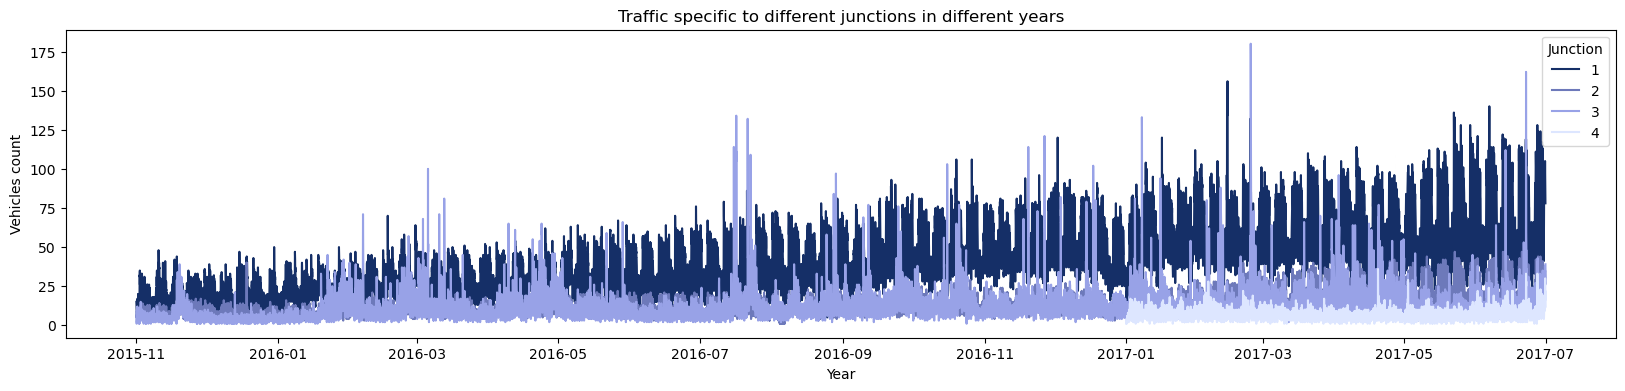

In [58]:
df=data.copy() 
plt.figure(figsize=(20,4))
colors = [ "#152F67","#6D79BA","#98A2E7","#DDE6FF"]
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic specific to different junctions in different years")
Time_series.set_ylabel("Vehicles count")
Time_series.set_xlabel("Year")
plt.plot()

**Information we got from above plot:**

- Number of vehicles count is increased with years which indicates upward trend.
- And data for fourth data is very less and its data is only available after 2017.
- Vehicles count may depend upon the time of the year, which is not included in the plot which needs to be explored. 

<p style="background-color:#152F67;color:#E7E7E7;font-size:150%;padding: 10px 0;text-align:center;border-radius:30px;">Feature Extraction</p>

To figure out clarity in traffic conditions based on time of the year, lets compute
- Year
- Month
- Date in the given month
- Days of the week
- Hour
from the Date composition column of the given data set.

In [59]:
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df['DateTime'].dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


<p style="background-color:#152F67;color:#E7E7E7;font-size:150%;padding: 10px 0;text-align:center;border-radius:30px;">Exploratory Data Analysis(EDA)</p>

First lets visualize the extracted features with year..

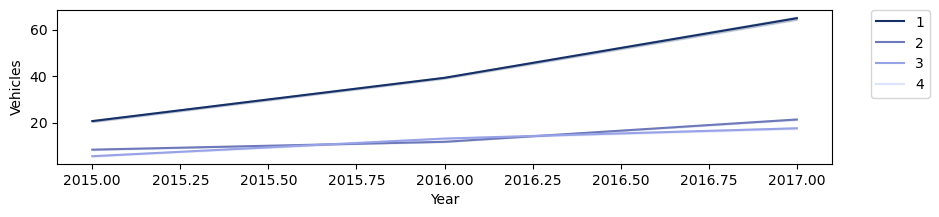

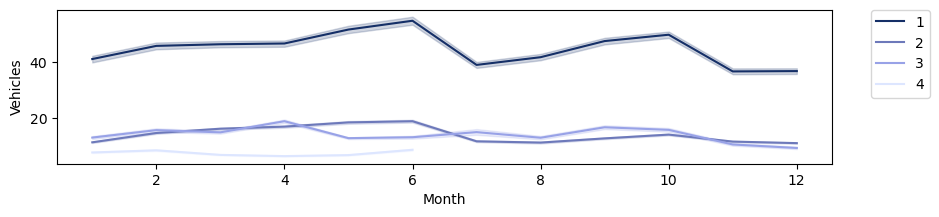

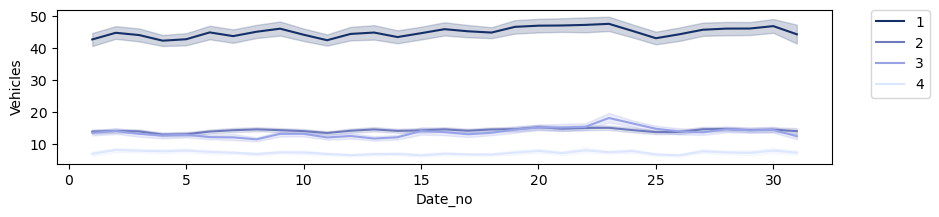

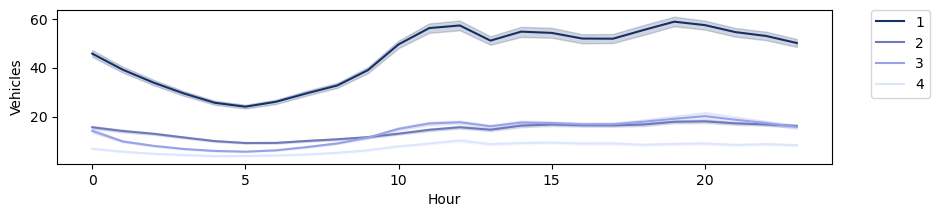

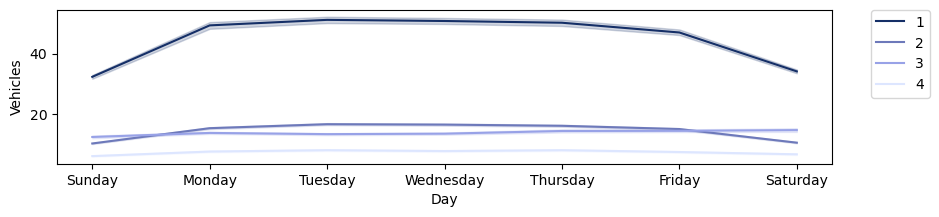

In [60]:
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2))
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Information we got from the above plot:**

- During 6th (June month), there is sudden increase in the number of vehicles in $1^{st}$ and $2^{nd}$ junction, we can assume that its may be due to summer break and other joyful activities people around that time.
- Considering year wise data, we can observe upward trend or increasing in the number of vehicles count except for the fourth junction which is sparse (limited data is available).
- Seeing month wise, data is consistent.
- Daily, we can observe peaks during morning and evening times and a decline during night hours.
- Observing weekly patterns, sundays got lesser vehicles as its a weekend and many tries to relax compared to other week days.

Text(0.5, 0, 'Year')

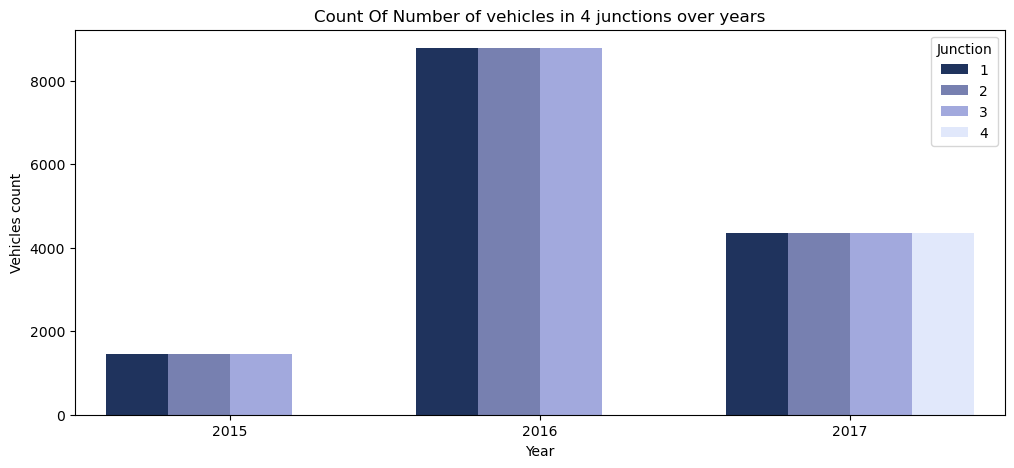

In [61]:
plt.figure(figsize=(12,5))
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Number of vehicles in 4 junctions over years")
count.set_ylabel("Vehicles count")
count.set_xlabel("Year")

**Information gained from above count plot:**

The count plot shows that there is an increase in the number of vehicles between 2015 and 2016. However, it is inconclusive to say the same about 2017 as we have limited data for 2017 i.e., till the 7th month. 

<AxesSubplot: >

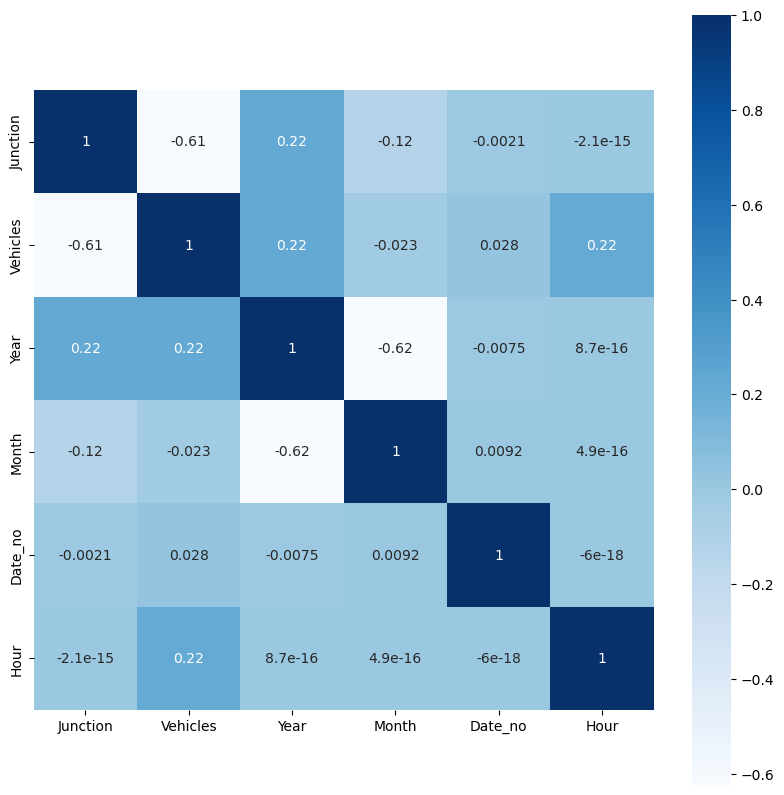

In [62]:
corrmat = df.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corrmat,cmap="Blues",annot=True,square=True, )

The highest correlation is certainly with the preexisting feature. 
Lets conclude our data analysis with a pair plot. It's an interesting overall representation of any data. 

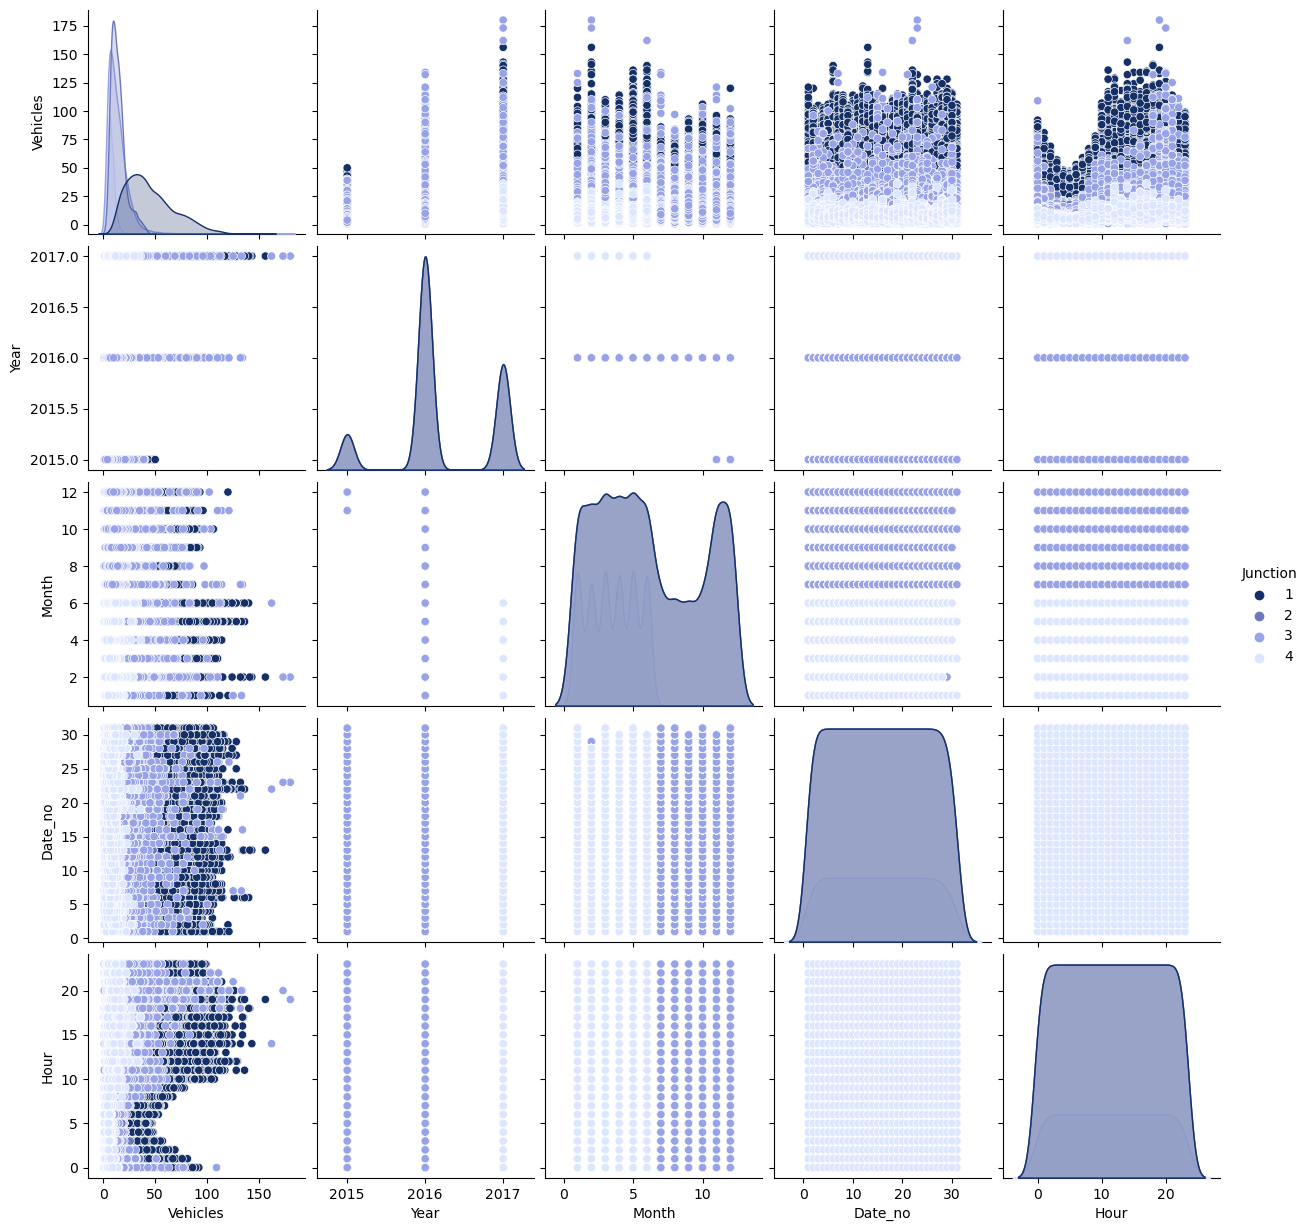

In [63]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

**Conclusions from above exploratory data analysis:**

* The span of data from all four junctions is not the same. Data provided for the fourth junction is limited to only 2017.
* The yearly trend for Junctions one, two and three have different slopes (trend of varying). 
* Junction number one has a more strong weekly seasonality in comparison to the other junctions. 

For the above-postulated reasons, we can think that junctions must be transformed as per their individual needs. 



<p style="background-color:#152F67;color:#E7E7E7;font-size:150%;padding: 10px 0;text-align:center;border-radius:30px;">Data Transformation & Preprocessing</p>


`Since ours is a mini project lets focus on first two junctions and preprocess the data as needed and model a classifier.`

In [64]:
#Pivoting data fron junction 
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

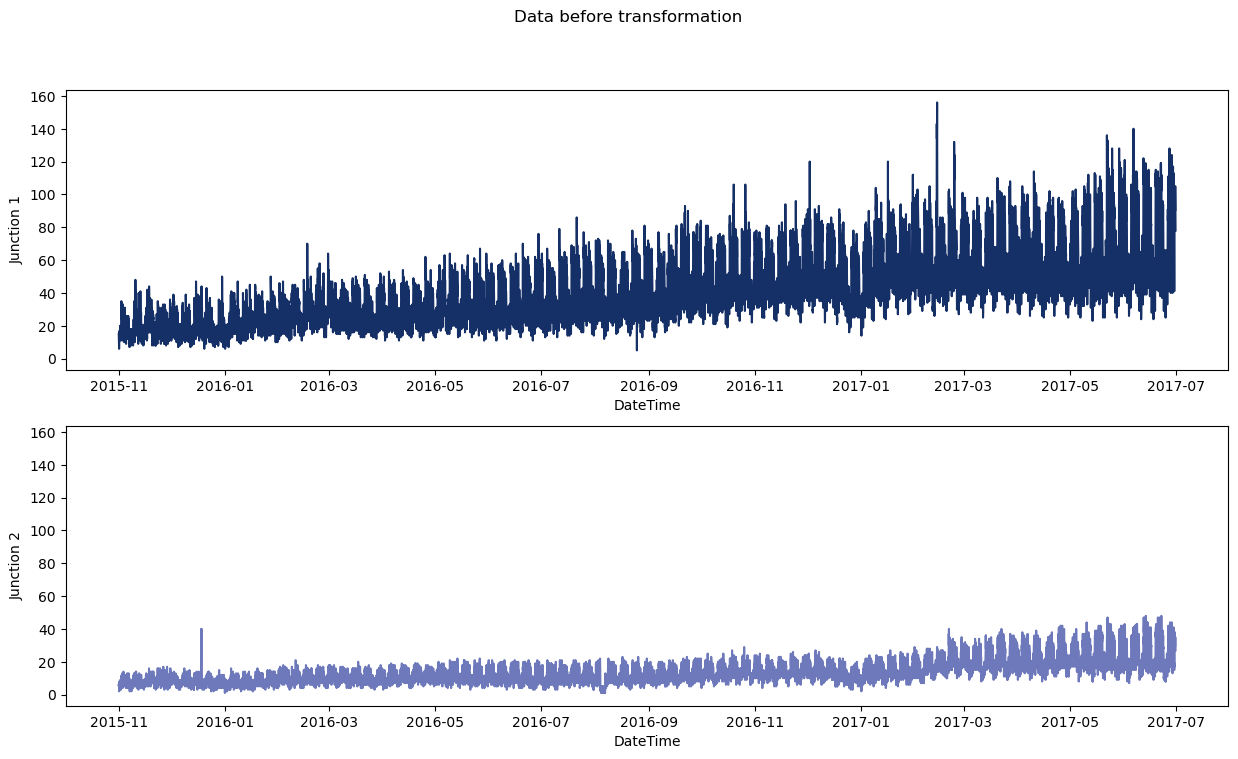

In [65]:
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]

list_dfs = [df_1, df_2]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

def Sub_Plots(df_1, df_2,title):
    fig, axes = plt.subplots(2, 1, figsize=(15, 8),sharey=True)
    fig.suptitle(title)
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    axes[0].set(ylabel ="Junction 1")
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    
    
Sub_Plots(df_1.Vehicles, df_2.Vehicles,"Data before transformation")

Lets transform the data according to our need, normalize and then take a difference between given interval.

In [66]:
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

According to above observations, differencing is done to eliminate variations in different times of the year,
- For junction 1, we can consider weekly values.
- For 2, days will be a better choice.

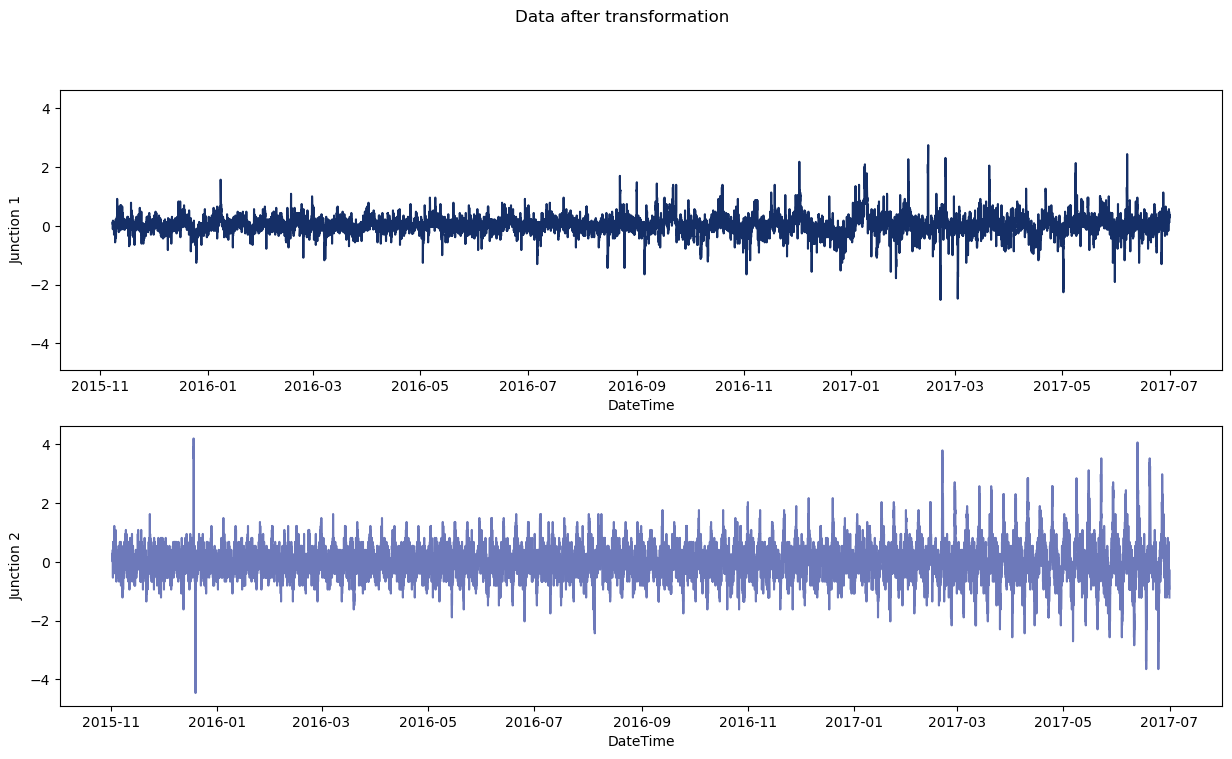

In [67]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

Sub_Plots(df_N1.Diff, df_N2.Diff,"Data after transformation")


The plots above seem linear. To ensure they are Stationary lets perform an Augmented Dickey-Fuller test. 

In [68]:
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values: ")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Data is Non-Stationary")
    else:
        print("Data is not Stationary") 
  


List_df_ND = [ df_N1["Diff"], df_N2["Diff"]] 
print("Checking whether the transformed data is stationary: ")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking whether the transformed data is stationary: 


ADF Statistic: -15.26530339041554
p-value: 4.798539876395238e-28
Critical Values: 
	1%: -3.431
	5%: -2.862
	10%: -2.567
Data is not Stationary


ADF Statistic: -21.7958910269401
p-value: 0.0
Critical Values: 
	1%: -3.431
	5%: -2.862
	10%: -2.567
Data is not Stationary


`Now as our data is stationary, lets preprocess the data for training our neural network.`

In [69]:
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()


def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)

def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

<p style="background-color:#152F67;color:#E7E7E7;font-size:150%;padding: 10px 0;text-align:center;border-radius:30px;">Data Transformation & Preprocessing</p>


According to studies, we have finalized to use `Gated Recurrent Unit` which was used by many for better results.

In [70]:
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=10, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("RMSE Error {}.".format(rmse))
    return rmse

def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5))
    plt.plot(test, color=colors[m],label="True Values",alpha=0.5 )
    plt.plot(predicted, color="#152F67",label="Predicted Values")
    plt.title("GRU Traffic Prediction vs True Values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

<p style="background-color:#152F67;color:#E7E7E7;font-size:150%;padding: 10px 0;text-align:center;border-radius:30px;">Fitting the model</p>

<p style="background-color:#152F67;color:#E7E7E7;font-size:150%;padding: 10px 0;text-align:center;border-radius:30px;">For Junction 1</p>

In [71]:
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/10
87/87 [==============================] - 14s 126ms/step - loss: 0.0767
Epoch 2/10
87/87 [==============================] - 12s 143ms/step - loss: 0.0658
Epoch 3/10
87/87 [==============================] - 12s 142ms/step - loss: 0.0645
Epoch 4/10
87/87 [==============================] - 12s 141ms/step - loss: 0.0631
Epoch 5/10
87/87 [==============================] - 13s 144ms/step - loss: 0.0631
Epoch 6/10
87/87 [==============================] - 12s 142ms/step - loss: 0.0605
Epoch 7/10
87/87 [==============================] - 12s 143ms/step - loss: 0.0602
Epoch 8/10
87/87 [==============================] - 13s 146ms/step - loss: 0.0589
Epoch 9/10
87/87 [==============================] - 14s 156ms/step - loss: 0.0578
Epoch 10/10
45/45 [==============================] - 1s 13ms/step


RMSE Error 0.2713674362938352.


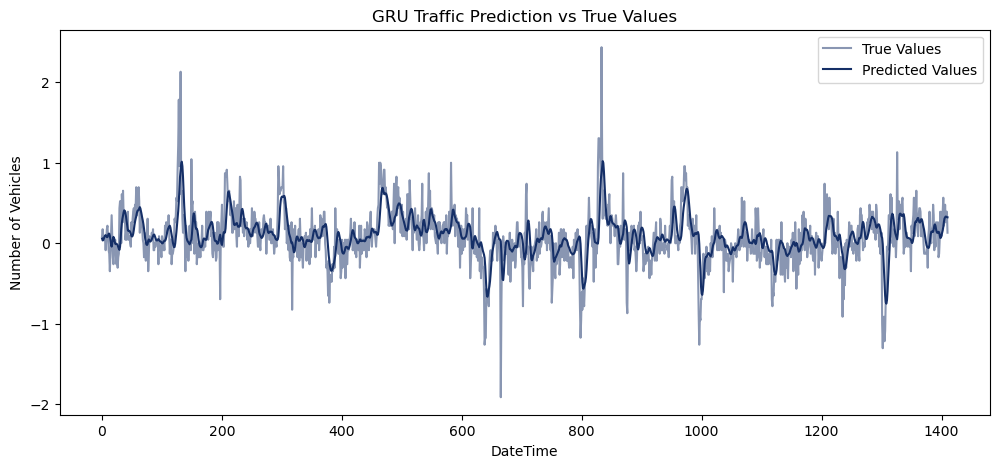

In [72]:
#Results for J1 
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

<p style="background-color:#152F67;color:#E7E7E7;font-size:150%;padding: 10px 0;text-align:center;border-radius:30px;">For Junction 2</p>

In [73]:

PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)

Epoch 1/10
88/88 [==============================] - 15s 138ms/step - loss: 0.2355
Epoch 2/10
88/88 [==============================] - 17s 191ms/step - loss: 0.2058
Epoch 3/10
88/88 [==============================] - 16s 179ms/step - loss: 0.1971
Epoch 4/10
88/88 [==============================] - 15s 174ms/step - loss: 0.1970
Epoch 5/10
88/88 [==============================] - 14s 164ms/step - loss: 0.1943
Epoch 6/10
88/88 [==============================] - 16s 182ms/step - loss: 0.1934
Epoch 7/10
88/88 [==============================] - 15s 176ms/step - loss: 0.1923
Epoch 8/10
88/88 [==============================] - 15s 175ms/step - loss: 0.1899
Epoch 9/10
88/88 [==============================] - 15s 172ms/step - loss: 0.1911
Epoch 10/10
45/45 [==============================] - 1s 15ms/step


RMSE Error 0.5797009652418714.


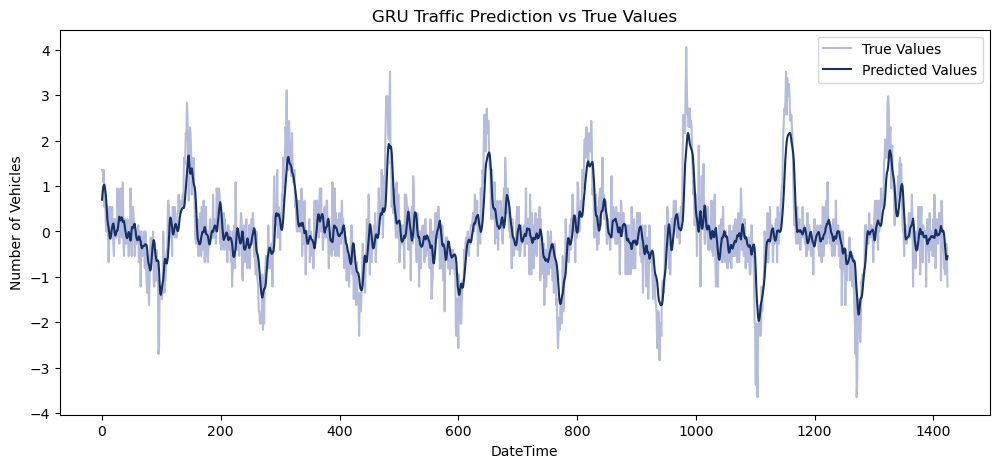

In [74]:
#Results for J2
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

**The results of the model** 

In [76]:
Junctions = ["Junction1", "Junction2"]
RMSE = [RMSE_J1, RMSE_J2]
list_of_tuples = list(zip(Junctions, RMSE))
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE"])
Results


,Junction,RMSE
0,Junction1,0.271367
1,Junction2,0.579701
